In [1]:
!pip install neuralhydrology
# import neuralhydrology
# print(neuralhydrology.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.9/179.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 7.4 MB/s eta 0:00:00


In [2]:
import os
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import Dict
from torch import Tensor
import pandas as pd

from neuralhydrology.modelzoo.handoff_forecast_lstm import HandoffForecastLSTM
from neuralhydrology.utils.config import Config

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# # Preprocess

In [3]:
DATA_DIR = "/kaggle/input/camels-caravan/final_dataset/camels"

attrs = pd.read_csv(os.path.join(DATA_DIR, "step5_static.csv"))
meteo = pd.read_csv(os.path.join(DATA_DIR, "step5_era5.csv"))
hres = pd.read_csv(os.path.join(DATA_DIR, "step5_ecmwf.csv"))
q = pd.read_csv(os.path.join(DATA_DIR, "step5_discharge.csv"))
precip = pd.read_csv(os.path.join(DATA_DIR, "step5_precip.csv"))

mean_q = q["q_obs"].mean()

q["q_obs"] = q["q_obs"].fillna(mean_q)

print(f"Đã fill NaN bằng mean ({mean_q:.4f}). Số lượng NaN còn lại: {q['q_obs'].isna().sum()}")

keys = ["grdc_no", "date"]

for _df in [meteo, hres, q, precip]:
    _df["date"] = pd.to_datetime(_df["date"])
    
flood_thr = (
    q.dropna(subset=["q_obs"])
     .groupby("grdc_no")["q_obs"]
     .quantile(0.95)
     .to_dict()
)

#######ablation###########
USE_METEO  = True    # ERA5
USE_HRES   = True    # ECMWF-HRES
USE_NOAA   = True    # NOAA precip
USE_STATIC = True    # Static basin attributes
USE_LOG    = True    # log1p transform

df = None

df = meteo.copy()

if USE_HRES:
    df = df.merge(hres, on=keys, how="inner")

if USE_NOAA:
    df = df.merge(precip, on=keys, how="inner")

# discharge luôn phải có
df = df.merge(q, on=keys, how="inner")

if USE_STATIC:
    df = df.merge(attrs, on="grdc_no", how="left")
    
df = df.sort_values(["grdc_no", "date"]).reset_index(drop=True)

LOG1P_COLS = []

if USE_METEO:
    LOG1P_COLS += ["tp_x"]

if USE_HRES:
    LOG1P_COLS += ["tp_y"]

if USE_NOAA:
    LOG1P_COLS += ["prep_NOAA"]

LOG1P_COLS += ["q_obs"]

for c in LOG1P_COLS:
    if c in df.columns:
        df[c] = np.log1p(np.clip(df[c].to_numpy(), 0, None))
    else:
        print(f"[warn] column not found, skipping log1p: {c}")
        
print("Total records:", len(df))
df.columns

Đã fill NaN bằng mean (100.7376). Số lượng NaN còn lại: 0
Total records: 25542


Index(['date', 'grdc_no', 't2m_x', 'sp_x', 'ssr_x', 'str_x', 'tp_x', 't2m_y',
       'sp_y', 'ssr_y', 'str_y', 'tp_y', 'prep_NOAA', 'q_obs', 'area',
       'mean_elevation', 'mean_slope', 'clay_fraction', 'sand_fraction',
       'silt_fraction', 'forest_cover', 'urban_cover', 'cropland_cover',
       'aridity_index', 'mean_precip'],
      dtype='object')

In [4]:
METEO_BASE = ["t2m", "tp", "sp", "ssr", "str"]
METEO_COLS = [f"{b}_x" for b in METEO_BASE] + ["prep_NOAA"]
METEO_COLS.remove("tp_x")
HRES_COLS  = [f"{b}_y" for b in METEO_BASE]
TARGET = "q_obs"

STATIC_COLS = [
    "area", "mean_elevation", "mean_slope",
    "clay_fraction", "sand_fraction", "silt_fraction",
    "forest_cover", "urban_cover", "cropland_cover",
    "aridity_index", "mean_precip"
]

SEQ_H = 365
SEQ_F = 1

In [5]:
# --- CHÈN VÀO SAU KHI TẠO XONG df VÀ TRƯỚC KHI CHUẨN HÓA/CHIA CỬA SỔ ---

# 1. Danh sách tất cả các cột numeric cần dùng
feature_cols = METEO_COLS + HRES_COLS + STATIC_COLS + ["q_obs"]

# 2. Kiểm tra xem còn bao nhiêu NaN
print("Số lượng NaN trước khi xử lý:")
print(df[feature_cols].isna().sum().sort_values(ascending=False).head(10))

# 3. Điền khuyết thiếu cho TOÀN BỘ các cột
# Với dữ liệu chuỗi thời gian, ffill (lấy giá trị ngày hôm trước đắp vào) thường tốt hơn mean
df[feature_cols] = df[feature_cols].ffill().bfill()

# Nếu vẫn còn (do ffill không được nếu NaN ở đầu), fill nốt bằng 0 hoặc mean
df[feature_cols] = df[feature_cols].fillna(0)

print("Đã xử lý xong toàn bộ NaN input.")
# -------------------------------------------------------------------------

Số lượng NaN trước khi xử lý:
prep_NOAA    3405
tp_y         3405
sp_x            0
ssr_x           0
str_x           0
t2m_x           0
t2m_y           0
sp_y            0
ssr_y           0
str_y           0
dtype: int64
Đã xử lý xong toàn bộ NaN input.


In [6]:
# --- TẠO MAPPING ID (String -> Int) ---
# Lấy danh sách các mã trạm duy nhất
unique_basins = df["grdc_no"].unique()

# Tạo từ điển ánh xạ
basin_str_to_int = {b: i for i, b in enumerate(unique_basins)}
basin_int_to_str = {i: b for i, b in enumerate(unique_basins)}

print(f"Đã tạo mapping cho {len(unique_basins)} trạm.")

# Chuyển đổi flood_thr (đang dùng key str) sang key int để dùng cho Loss function
# Lưu ý: flood_thr đã được tính ở cell Preprocess
flood_thr_int = {basin_str_to_int[b]: v for b, v in flood_thr.items() if b in basin_str_to_int}
print(f"Đã convert {len(flood_thr_int)} ngưỡng lũ sang key int.")

Đã tạo mapping cho 14 trạm.
Đã convert 14 ngưỡng lũ sang key int.


In [7]:
def compute_norm_stats(df, basin_ids):
    df_sub = df[df["grdc_no"].isin(basin_ids)].copy()

    basin_static = df_sub.groupby("grdc_no")[STATIC_COLS].first()

    stats = {
        "ATTR_MEAN": basin_static.mean(),
        "ATTR_STD":  basin_static.std().replace(0, 1.0),

        "HRES_MEAN": df_sub[HRES_COLS].mean(),
        "HRES_STD":  df_sub[HRES_COLS].std().replace(0, 1.0),

        "METEO_MEAN": df_sub[METEO_COLS].mean(),
        "METEO_STD":  df_sub[METEO_COLS].std().replace(0, 1.0),
    }
    return stats

In [8]:
def make_data_for_nh(df_basin, t_idx, stats):
    df_basin = df_basin.sort_values("date").reset_index(drop=True)

    start = t_idx - SEQ_H
    end   = t_idx + SEQ_F
    assert start >= 0 and end <= len(df_basin)

    window = df_basin.iloc[start:end]

    hind = window.iloc[:SEQ_H]
    fore = window.iloc[SEQ_H:]

    x_d_hindcast = {}
    for c in HRES_COLS:
        vals = ((hind[c] - stats["HRES_MEAN"][c]) / stats["HRES_STD"][c]).to_numpy(dtype=np.float32)
        x_d_hindcast[c] = torch.tensor(vals).unsqueeze(-1).unsqueeze(0)   # (1, SEQ_H, 1)

    x_d_forecast = {}
    for c in METEO_COLS:
        vals = ((fore[c] - stats["METEO_MEAN"][c]) / stats["METEO_STD"][c]).to_numpy(dtype=np.float32)
        x_d_forecast[c] = torch.tensor(vals).unsqueeze(-1).unsqueeze(0)   # (1, SEQ_F, 1)

    # static attributes (normalized)
    x_s_vals = ((window.iloc[0][STATIC_COLS] - stats["ATTR_MEAN"]) / stats["ATTR_STD"]).to_numpy(dtype=np.float32)
    x_s = torch.tensor(x_s_vals).unsqueeze(0)

    y = torch.tensor(
        window[[TARGET]].values, dtype=torch.float32
    ).unsqueeze(0)                  # (1, SEQ_H+SEQ_F, 1)

    data = {
        "x_d_hindcast": x_d_hindcast,
        "x_d_forecast": x_d_forecast,
        "x_s": x_s,
        "y": y
    }

    return data

print("Total basins:", df["grdc_no"].nunique())
print("SEQ_H:", SEQ_H, "SEQ_F:", SEQ_F)
total_windows = 0

for basin, df_basin in df.groupby("grdc_no"):
    n_days = len(df_basin)
    n_windows = max(0, n_days - SEQ_H - SEQ_F + 1)
    total_windows += n_windows
print("Total samples after windowing:", total_windows)



Total basins: 14
SEQ_H: 365 SEQ_F: 1
Total samples after windowing: 20432


In [9]:
cfg = Config({
    "model": "HandoffForecastLSTM",

    # ----- sequence -----
    "seq_length": SEQ_H + SEQ_F,      # 366
    "forecast_seq_length": SEQ_F,     # 1

    # ----- inputs -----
    "hindcast_inputs": [HRES_COLS],
    "forecast_inputs": [METEO_COLS],
    "dynamic_inputs": [HRES_COLS + METEO_COLS],

    "static_attributes": STATIC_COLS,

    # ----- embeddings -----
    "statics_embedding": {
        "type": "fc",
        "hiddens": [32],
        "activation": "tanh",
        "dropout": 0.0
    },

    "dynamics_embedding": {
        "type": "fc",
        "hiddens": [64],
        "activation": "tanh",
        "dropout": 0.0
    },

    # ----- model params -----
    "hidden_size": 128,
    "initial_forget_bias": 1.0,
    "output_dropout": 0.0,

    # ----- head -----
    "head": "regression",
    "target_variables": [TARGET],

    # ----- required -----
    "nan_handling_method": None,
    "timestep_counter": False,

    "state_handoff_network": {
        "type": "fc",
        "hiddens": [128],
        "activation": "tanh",
        "dropout": 0.0
    },

})


In [10]:
model = HandoffForecastLSTM(cfg)
model.train()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


HandoffForecastLSTM(
  (forecast_embedding_net): InputLayer(
    (statics_embedding): FC(
      (net): Sequential(
        (0): Linear(in_features=11, out_features=32, bias=True)
      )
    )
    (dynamics_embeddings): ModuleList(
      (0): FC(
        (net): Sequential(
          (0): Linear(in_features=5, out_features=64, bias=True)
        )
      )
    )
  )
  (hindcast_embedding_net): InputLayer(
    (statics_embedding): FC(
      (net): Sequential(
        (0): Linear(in_features=11, out_features=32, bias=True)
      )
    )
    (dynamics_embeddings): ModuleList(
      (0): FC(
        (net): Sequential(
          (0): Linear(in_features=5, out_features=64, bias=True)
        )
      )
    )
  )
  (hindcast_lstm): LSTM(96, 128)
  (forecast_lstm): LSTM(96, 128)
  (handoff_net): FC(
    (net): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
    )
  )
  (handoff_linear): FC(
    (net): Sequential(
      (0): Linear(in_features=128, out_features=256, bia

In [11]:
def preprocess_basins(df):
    basins = {}

    for basin, df_basin in df.groupby("grdc_no"):
        df_basin = df_basin.sort_values("date").reset_index(drop=True)

        basins[basin] = {
            "df": df_basin,
            "n_days": len(df_basin)
        }

    return basins

basins = preprocess_basins(df)

# Keep a copy of all basins for CV splits
basins_all = basins


In [12]:
class HydroWindowDataset(Dataset):
    def __init__(self, basins, seq_h, seq_f):
        self.samples = []
        self.basins = basins
        self.seq_h = seq_h
        self.seq_f = seq_f

        for basin, d in basins.items():
            n = d["n_days"]
            for t in range(seq_h, n - seq_f + 1):
                self.samples.append((basin, t))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]   # (basin_id, t_idx)


dataset = HydroWindowDataset(basins, SEQ_H, SEQ_F)
print("Total samples:", len(dataset))  # ~31588

def make_collate_fn(basins_dict, stats, basin_map):
    def collate_fn(batch):
        x_d_h, x_d_f, x_s, y = {}, {}, [], []
        basin_ids = []
        
        for c in HRES_COLS:
            x_d_h[c] = []
        for c in METEO_COLS:
            x_d_f[c] = []

        for basin, t_idx in batch:
            basin_ids.append(basin_map[basin]) 
            
            df_basin = basins_dict[basin]["df"]
            data = make_data_for_nh(df_basin, t_idx, stats)

            for c in HRES_COLS:
                x_d_h[c].append(data["x_d_hindcast"][c][0])
            for c in METEO_COLS:
                x_d_f[c].append(data["x_d_forecast"][c][0])

            x_s.append(data["x_s"][0])
            y.append(data["y"][0])

        for k in x_d_h:
            x_d_h[k] = torch.stack(x_d_h[k], dim=0)
        for k in x_d_f:
            x_d_f[k] = torch.stack(x_d_f[k], dim=0)

        x_s = torch.stack(x_s, dim=0)
        y   = torch.stack(y, dim=0)

        return {"basin_id": torch.tensor(basin_ids, dtype=torch.long), "x_d_hindcast": x_d_h, "x_d_forecast": x_d_f, "x_s": x_s, "y": y}

    return collate_fn

def train_one_epoch(model, loader, optimizer, loss_fn, device, epoch):
    model.train()
    total_loss = 0.0

    for batch_idx, data in enumerate(loader, start=1):

        # move to device
        for k in data["x_d_hindcast"]:
            data["x_d_hindcast"][k] = data["x_d_hindcast"][k].to(device)
        for k in data["x_d_forecast"]:
            data["x_d_forecast"][k] = data["x_d_forecast"][k].to(device)

        data["x_s"] = data["x_s"].to(device)
        data["y"]   = data["y"].to(device)

        optimizer.zero_grad()

        # forward
        out = model(data)

        y_true = data["y"]
        y_true_f = y_true[:, -cfg.forecast_seq_length:, :]

        y_hat = out["y_hat"]
        y_pred = y_hat[:, -cfg.forecast_seq_length:, :]
        # if batch_idx == 1:
        #     print("y_true_f min/max:",
        #           y_true_f.min().item(),
        #           y_true_f.max().item())
        #     print("y_pred min/max:",
        #           y_pred.min().item(),
        #           y_pred.max().item())


        loss = loss_fn(y_pred, y_true_f)

        # backward
        loss.backward()
        optimizer.step()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        batch_loss = loss.item()
        total_loss += batch_loss

        # 🔹 LOG BATCH LOSS
        if batch_idx % 50 == 0 or batch_idx == 1:
            print(
                f"[Epoch {epoch:03d}] "
                f"Batch {batch_idx:05d}/{len(loader)} | "
                f"Batch Loss: {batch_loss:.6f}"
            )

    # 🔹 EPOCH LOSS
    avg_loss = total_loss / len(loader)

    print(
        f"===== Epoch {epoch:03d} DONE | "
        f"Avg Loss: {avg_loss:.6f} ====="
    )

    return avg_loss


Total samples: 20432


# Helpers

In [13]:
def basin_window_counts(basins_dict, seq_h, seq_f):
    counts = {}
    for b, d in basins_dict.items():
        n = int(d["n_days"])
        counts[b] = max(0, n - seq_h - seq_f + 1)
    return counts

def greedy_test_split_by_windows(basin_ids, counts, test_frac=0.10):
    basin_ids = sorted(basin_ids, key=lambda b: counts.get(b, 0), reverse=True)
    total = sum(counts.get(b, 0) for b in basin_ids)
    target = test_frac * total

    test, s = [], 0
    for b in basin_ids:
        if s < target:
            test.append(b)
            s += counts.get(b, 0)
    train = [b for b in basin_ids if b not in set(test)]
    return train, test

@torch.no_grad()
def predict_all(model, loader, device):
    model.eval()
    ys, yps, bids = [], [], []

    for data in loader:
        # keep basin ids on CPU
        b = data["basin_id"]
        if torch.is_tensor(b):
            bids.append(b.cpu().numpy().reshape(-1))
        else:
            bids.append(np.asarray(b).reshape(-1))

        for k in data["x_d_hindcast"]:
            data["x_d_hindcast"][k] = data["x_d_hindcast"][k].to(device)
        for k in data["x_d_forecast"]:
            data["x_d_forecast"][k] = data["x_d_forecast"][k].to(device)

        data["x_s"] = data["x_s"].to(device)
        data["y"]   = data["y"].to(device)

        out = model(data)

        y_true = data["y"][:, -cfg.forecast_seq_length:, :].detach().cpu().numpy().reshape(-1)
        y_pred = out["y_hat"][:, -cfg.forecast_seq_length:, :].detach().cpu().numpy().reshape(-1)

        ys.append(y_true)
        yps.append(y_pred)

    return np.concatenate(bids, axis=0), np.concatenate(ys, axis=0), np.concatenate(yps, axis=0)

@torch.no_grad()
def eval_one_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0.0

    for data in loader:
        # move to device
        for k in data["x_d_hindcast"]:
            data["x_d_hindcast"][k] = data["x_d_hindcast"][k].to(device)
        for k in data["x_d_forecast"]:
            data["x_d_forecast"][k] = data["x_d_forecast"][k].to(device)

        data["x_s"] = data["x_s"].to(device)
        data["y"]   = data["y"].to(device)

        out = model(data)

        y_true = data["y"]
        y_true_f = y_true[:, -cfg.forecast_seq_length:, :]

        y_pred = out["y_hat"][:, -cfg.forecast_seq_length:, :]

        # supports both MSELoss(y_pred,y_true) and WeightedMSELoss(y_pred,y_true,basin_id)
        try:
            loss = loss_fn(y_pred, y_true_f, data["basin_id"].to(device))
        except TypeError:
            loss = loss_fn(y_pred, y_true_f)

        total_loss += loss.item()

    return total_loss / len(loader)

def regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    e = y_pred - y_true
    mse = float(np.mean(e**2))
    rmse = float(np.sqrt(mse))
    bias = float(np.mean(e))

    ss_res = float(np.sum((y_true - y_pred) ** 2))
    ss_tot = float(np.sum((y_true - np.mean(y_true)) ** 2))

    r = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r**2

    nse = float(1.0 - ss_res / ss_tot) if ss_tot > 0 else float("nan")

    return {"MSE": mse, "RMSE": rmse, "Bias": bias, "R2": r2, "NSE": nse}


In [14]:
def _metrics_from_counts(tp, fp, tn, fn):
    tp, fp, tn, fn = map(float, (tp, fp, tn, fn))
    precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    recall    = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else np.nan
    acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else np.nan
    bal_acc = (recall + specificity) / 2 if (not np.isnan(recall) and not np.isnan(specificity)) else np.nan
    return {"precision": precision, "recall": recall, "f1": f1,
            "accuracy": acc, "specificity": specificity, "balanced_acc": bal_acc,
            "tp": tp, "fp": fp, "tn": tn, "fn": fn}

def flood_metrics_fixed_thr(basin_id, y_true_q, y_pred_q, flood_thr):
    basin_id = np.asarray(basin_id).reshape(-1)
    y_true_q = np.asarray(y_true_q).reshape(-1)
    y_pred_q = np.asarray(y_pred_q).reshape(-1)

    rows = []
    TP = FP = TN = FN = 0

    for b in np.unique(basin_id):
        thr = flood_thr.get(int(b), None)
        if thr is None:
            continue

        m = basin_id == b
        yt = y_true_q[m]
        yp = y_pred_q[m]

        yt_bin = yt >= thr
        yp_bin = yp >= thr

        tp = int(np.sum(yt_bin & yp_bin))
        fp = int(np.sum(~yt_bin & yp_bin))
        tn = int(np.sum(~yt_bin & ~yp_bin))
        fn = int(np.sum(yt_bin & ~yp_bin))

        met = _metrics_from_counts(tp, fp, tn, fn)
        met.update({"basin_id": int(b), "thr_q": float(thr), "n": int(yt.size), "pos_rate": float(yt_bin.mean())})
        rows.append(met)

        TP += tp; FP += fp; TN += tn; FN += fn

    per_basin = pd.DataFrame(rows).sort_values("basin_id").reset_index(drop=True)

    micro = _metrics_from_counts(TP, FP, TN, FN)
    micro.update({"support": int(len(y_true_q)), "basins": int(len(per_basin))})

    macro = per_basin[["precision","recall","f1","accuracy","specificity","balanced_acc"]].mean(numeric_only=True).to_dict()
    macro.update({"basins": int(len(per_basin))})

    return micro, macro, per_basin

# Training

In [15]:
counts = basin_window_counts(basins_all, SEQ_H, SEQ_F)
basin_ids = list(basins_all.keys())

trainval_ids, test_ids = greedy_test_split_by_windows(basin_ids, counts, test_frac=0.10)

val_frac_of_trainval = 0.1 / 0.9
train_ids, val_ids = greedy_test_split_by_windows(trainval_ids, counts, test_frac=val_frac_of_trainval)

def _count_windows(ids):
    return sum(counts[b] for b in ids)

n_all  = _count_windows(basin_ids)
n_tr   = _count_windows(train_ids)
n_val  = _count_windows(val_ids)
n_test = _count_windows(test_ids)

print("Basins total:", len(basin_ids))
print("Train basins:", len(train_ids), "windows:", n_tr, "frac:", n_tr/n_all)
print("Val basins:", len(val_ids), "windows:", n_val, "frac:", n_val/n_all)
print("Test basins:", len(test_ids), "windows:", n_test,"frac:", n_test/n_all)


BATCH_SIZE = 64  # Tăng lên chút nếu GPU mạnh
MAX_EPOCHS = 30
PATIENCE = 10
MIN_DELTA = 1e-6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Hàm tính threshold giữ nguyên, nhưng kết quả sẽ được map sang int ở dưới ---
def compute_flood_thr_log(q_df, basin_ids, pct=0.95):
    sub = q_df[q_df["grdc_no"].isin(basin_ids)].dropna(subset=["q_obs"])
    thr_q = sub.groupby("grdc_no")["q_obs"].quantile(pct)
    thr_log = np.log1p(thr_q)
    return thr_log.to_dict()

class WeightedMSELoss(torch.nn.Module):
    def __init__(self, thr_log_dict, pos_weight=10.0, base_weight=1.0):
        super().__init__()
        self.thr_log_dict = thr_log_dict
        self.pos_weight = float(pos_weight)
        self.base_weight = float(base_weight)

    def forward(self, y_pred, y_true, basin_id):
        # basin_id: (B,) bây giờ đã là INT (0, 1, 2...) nhờ collate_fn sửa đổi
        if torch.is_tensor(basin_id):
            basin_list = basin_id.detach().cpu().tolist()
        else:
            basin_list = list(basin_id)

        # Lấy threshold từ dict (key là int)
        thr = torch.tensor(
            [self.thr_log_dict[int(b)] for b in basin_list],
            device=y_true.device,
            dtype=y_true.dtype
        ).view(-1, 1, 1)

        w = torch.full_like(y_true, self.base_weight)
        alpha = 6.0
        p = torch.sigmoid(alpha * (y_true - thr))
        w = self.base_weight + (self.pos_weight - self.base_weight) * p

        return (w * (y_pred - y_true) ** 2).mean()

# Tính threshold gốc (Key là String)
thr_log_trainval = compute_flood_thr_log(q, train_ids + val_ids, pct=0.95)

# --- QUAN TRỌNG: Convert threshold sang Key Int ---
thr_log_trainval_int = {basin_str_to_int[b]: v for b, v in thr_log_trainval.items() if b in basin_str_to_int}

# Truyền dict Key Int vào Loss Function
train_loss_fn = torch.nn.MSELoss()
val_loss_fn = torch.nn.MSELoss()

cfg_base = cfg
cfg_dict_base = cfg.as_dict()

Basins total: 14
Train basins: 12 windows: 15556 frac: 0.7613547376664056
Val basins: 1 windows: 2438 frac: 0.11932263116679719
Test basins: 1 windows: 2438 frac: 0.11932263116679719


[Epoch 001] Batch 00001/244 | Batch Loss: 8.925082
[Epoch 001] Batch 00050/244 | Batch Loss: 2.786191
[Epoch 001] Batch 00100/244 | Batch Loss: 0.743801
[Epoch 001] Batch 00150/244 | Batch Loss: 0.455931
[Epoch 001] Batch 00200/244 | Batch Loss: 0.535247
===== Epoch 001 DONE | Avg Loss: 1.714589 =====
[Epoch 001] train_loss=1.714589  val_loss=2.061601
[Epoch 002] Batch 00001/244 | Batch Loss: 0.282219
[Epoch 002] Batch 00050/244 | Batch Loss: 0.245870
[Epoch 002] Batch 00100/244 | Batch Loss: 0.235858
[Epoch 002] Batch 00150/244 | Batch Loss: 0.574308
[Epoch 002] Batch 00200/244 | Batch Loss: 0.268939
===== Epoch 002 DONE | Avg Loss: 0.353833 =====
[Epoch 002] train_loss=0.353833  val_loss=3.593435
[Epoch 003] Batch 00001/244 | Batch Loss: 0.221482
[Epoch 003] Batch 00050/244 | Batch Loss: 0.276244
[Epoch 003] Batch 00100/244 | Batch Loss: 0.258887
[Epoch 003] Batch 00150/244 | Batch Loss: 0.391597
[Epoch 003] Batch 00200/244 | Batch Loss: 0.329166
===== Epoch 003 DONE | Avg Loss: 0.31

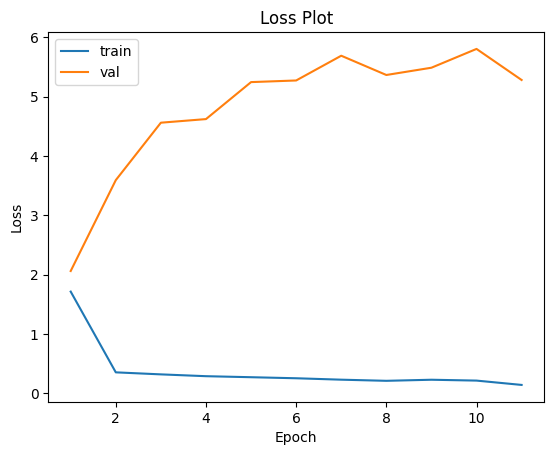


TEST metrics (log1p space): {'MSE': 2.1782023906707764, 'RMSE': 1.4758734331475638, 'Bias': -1.1065645217895508, 'R2': np.float64(0.02737101554876329), 'NSE': -2.04766298938288}
TEST metrics (original q): {'MSE': 59516.15234375, 'RMSE': 243.95932518301078, 'Bias': -130.61679077148438, 'R2': np.float64(0.01968475760134591), 'NSE': -0.3743450708974534}


KeyError: 'basin_id'

In [16]:
best_hp = {'name': 'hs256_lr1e-3_wd1e-4_do0.1', 'hidden_size': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'output_dropout': 0.0}
final_epochs = MAX_EPOCHS
basins_train = {b: basins_all[b] for b in train_ids}
basins_val = {b: basins_all[b] for b in val_ids}
basins_test = {b: basins_all[b] for b in test_ids}

stats_train = compute_norm_stats(df, train_ids)
basins = basins_train
train_ds = HydroWindowDataset(basins, SEQ_H, SEQ_F)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0,
                             collate_fn=make_collate_fn(basins, stats_train, basin_str_to_int))
basins = basins_val
val_ds = HydroWindowDataset(basins, SEQ_H, SEQ_F)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0,
                            collate_fn=make_collate_fn(basins, stats_train, basin_str_to_int))

cfg_final_dict = copy.deepcopy(cfg_dict_base)
cfg_final_dict["hidden_size"] = best_hp["hidden_size"]
cfg_final_dict["output_dropout"] = best_hp["output_dropout"]
cfg = Config(cfg_final_dict)

final_model = HandoffForecastLSTM(cfg).to(device)
final_opt = torch.optim.Adam(final_model.parameters(), lr=best_hp["lr"], weight_decay=best_hp["weight_decay"])

best_val = float("inf")
best_state = None
bad_epochs = 0

history = {"epoch": [], "train_loss": [], "val_loss": []}

for epoch in range(1, MAX_EPOCHS + 1):
    train_loss = train_one_epoch(final_model, train_loader, final_opt, train_loss_fn, device, epoch)
    val_loss = eval_one_epoch(final_model, val_loader, val_loss_fn, device)

    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    print(f"[Epoch {epoch:03d}] train_loss={train_loss:.6f}  val_loss={val_loss:.6f}")

    if val_loss < best_val - MIN_DELTA:
        best_val = val_loss
        best_state = copy.deepcopy(final_model.state_dict())
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print(f"Early stopping at epoch {epoch:03d} (best val_loss={best_val:.6f})")
            break

# load best checkpoint
if best_state is not None:
    final_model.load_state_dict(best_state)

plt.figure()
plt.plot(history["epoch"], history["train_loss"], label="train")
plt.plot(history["epoch"], history["val_loss"], label="val")
plt.title("Loss Plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("/kaggle/working/loss.png", dpi=200)
plt.show()

# -------------------------
# Evaluate on TEST (10% held-out basins)
# -------------------------
basins_test = {b: basins_all[b] for b in test_ids}
basins = basins_test
test_ds = HydroWindowDataset(basins, SEQ_H, SEQ_F)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0,
                         collate_fn=make_collate_fn(basins_test, stats_train, basin_str_to_int))


basin_id, y_true_log, y_pred_log = predict_all(final_model, test_loader, device)

# metrics in log space
m_log = regression_metrics(y_true_log, y_pred_log)

# invert log1p back to original discharge units
y_true_q = np.expm1(y_true_log)
y_pred_q = np.expm1(y_pred_log)
y_true_q = np.clip(y_true_q, 0, None)
y_pred_q = np.clip(y_pred_q, 0, None)

m_q = regression_metrics(y_true_q, y_pred_q)
print("\nTEST metrics (log1p space):", m_log)
print("TEST metrics (original q):", m_q)

micro, macro, per_basin = flood_metrics_fixed_thr(basin_id, y_true_q, y_pred_q, flood_thr)

print("\nFLOOD (top 5% per basin, full-series threshold) — MICRO:")
print({k: micro[k] for k in ["precision","recall","f1","accuracy","balanced_acc","support","basins"]})

print("\nFLOOD (top 5% per basin, full-series threshold) — MACRO:")
print({k: macro[k] for k in ["precision","recall","f1","accuracy","balanced_acc","basins"]})

In [ ]:
print("\n Shapes:")
print("basin_id:", np.asarray(basin_id).shape)
print("y_true_q:", np.asarray(y_true_q).shape)
print("y_pred_q:", np.asarray(y_pred_q).shape)

# per-sample threshold array aligned with y_true_q/y_pred_q
thr_arr = np.array([flood_thr[int(b)] for b in np.asarray(basin_id).reshape(-1)], dtype=np.float32)

true_pos = (y_true_q >= thr_arr)
pred_pos = (y_pred_q >= thr_arr)

print("\n Overall rates:")
print("true flood rate:", true_pos.mean()")
print("pred flood rate:", pred_pos.mean()")
print("n_true_flood:", int(true_pos.sum()))
print("n_pred_flood:", int(pred_pos.sum()))

# confusion matrix counts
TP = int(np.sum(true_pos & pred_pos))
FP = int(np.sum(~true_pos & pred_pos))
TN = int(np.sum(~true_pos & ~pred_pos))
FN = int(np.sum(true_pos & ~pred_pos))
print("\nConfusion:")
print({"TP": TP, "FP": FP, "TN": TN, "FN": FN})

# distribution sanity check
print("\n Global quantiles (q-space):")
print("y_true_q:", np.quantile(y_true_q, [0.5, 0.9, 0.95, 0.99]))
print("y_pred_q:", np.quantile(y_pred_q, [0.5, 0.9, 0.95, 0.99]))
print("thr_arr :", np.quantile(thr_arr,  [0.5, 0.9, 0.95, 0.99]))

# per-basin breakdown: does any basin ever get predicted floods?
print("\n Per-basin breakdown:")
for b in np.unique(np.asarray(basin_id).reshape(-1)):
    m = (np.asarray(basin_id).reshape(-1) == b)
    thr = flood_thr[int(b)]
    yt = y_true_q[m]
    yp = y_pred_q[m]
    tp = int(np.sum((yt >= thr) & (yp >= thr)))
    fn = int(np.sum((yt >= thr) & (yp <  thr)))
    fp = int(np.sum((yt <  thr) & (yp >= thr)))
    print(f"basin {int(b)} | thr={thr:.3f} | true_pos={int((yt>=thr).sum())}/{yt.size} "
          f"| pred_pos={int((yp>=thr).sum())}/{yp.size} | TP={tp} FP={fp} FN={fn} "
          f"| pred_q95={np.quantile(yp,0.95):.3f} pred_q99={np.quantile(yp,0.99):.3f}")

In [ ]:
os.makedirs("outputs", exist_ok=True)
save_path = "outputs/handoff_lstm_best_cv.pt"

torch.save(
    {
        "state_dict": final_model.state_dict(),
        "cfg": cfg.as_dict(),
        "best_hp": best_hp,
        "final_epochs": final_epochs,
        "test_metrics_log": m_log,
        "test_metrics_q": m_q,
        "test_basins": test_ids
    },
    save_path
)

print("Saved model to:", save_path)